In [1]:
%matplotlib inline
import sys
sys.version

'3.7.9 (default, Jan 24 2021, 23:57:56) \n[GCC 10.2.0]'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import json_normalize
import json
from matplotlib.ticker import MaxNLocator

In [3]:
filename = "../../../long-results/2021-07-03T21:00:21_inv_allIhave_120000_10_600000_120000_24.json"
#filename = "../../../long-results/2021-07-03T23:00:09_inv_allIhaveDOUBLE_120000_4_600000_120000_8.json"

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

ps = filename.split("_")
trps = dotdict({
    'p0': int(ps[3])/1000,
    'p0t': int(ps[4]),
    'p1': int(ps[5])/1000,
    'p2': int(ps[6])/1000,
    "p2t": int(ps[7].replace(".json", ""))
})

In [4]:
dict_for_colors = {}
get_counter_of_pid_list = []
available_colors = ['g','r','c','m','y','k']*1000000

def assign_color_to_hostname_pid(hostname, pid) -> str:
    key = hostname + pid
    if not key in dict_for_colors:
        dict_for_colors[key] = available_colors[len(dict_for_colors)]
    return dict_for_colors[key]

def get_uid_of_ri(pid, hostname, accelerator) -> int:
    key = str(pid) + str(hostname) + str(accelerator)
    try:
        val =  get_counter_of_pid_list.index(key)
        return val
    except Exception:
        get_counter_of_pid_list.append(key)
        return get_counter_of_pid_list.index(key)

def accelerator_type_from_accelerator(acc) -> str:
    if acc == "mycpu":
        return "cpu"
    if acc == "0" or acc == "1":
        return "gpu"
    if acc == "main.py": ## I don't understand this either
        return "vpu"

In [5]:
with open(filename) as f:
    d = json.load(f)
data = json_normalize(d)

print(data)

failed = [end == -1 for end in data['end']]
data.insert(0, "failed", failed)

if data.start.min() != 0:
    global experiment_start
    experiment_start = data.start.min()

data.start = data.start - experiment_start
data.end = data.end - experiment_start
data['result.start_computation'] = data['result.start_computation'] - experiment_start
data['result.end_computation'] = data['result.end_computation'] - experiment_start
data['result.metadata.start'] = data['result.metadata.start'] - experiment_start
data['result.metadata.end'] = data['result.metadata.end'] - experiment_start

# End to End Latency
data.insert(0,"rlat",data.end - data.start)

# Distr
data.insert(0, "dlat", data.rlat - data['result.metadata.inference_ms'])

data

                 end          start       inv.configuration  \
0      1625337954077  1625337946712  test|tinyyolov2-7.onnx   
1      1625337955052  1625337946712  test|tinyyolov2-7.onnx   
2      1625337954989  1625337946712  test|tinyyolov2-7.onnx   
3      1625337954487  1625337946712  test|tinyyolov2-7.onnx   
4      1625337954179  1625337946712  test|tinyyolov2-7.onnx   
...              ...            ...                     ...   
14215  1625338795768  1625338778941  test|tinyyolov2-7.onnx   
14216  1625338798277  1625338779000  test|tinyyolov2-7.onnx   
14217  1625338798018  1625338778875  test|tinyyolov2-7.onnx   
14218  1625338796423  1625338778979  test|tinyyolov2-7.onnx   
14219  1625338796629  1625338778891  test|tinyyolov2-7.onnx   

          inv.params.callbackUrl inv.params.payload  \
0      localhost:3358/74zkNRxGCA                      
1      localhost:3358/hP25rnXQ1k                      
2      localhost:3358/B7f2Ykg3Z3                      
3      localhost:3358/Z

,dlat,rlat,failed,end,start,inv.configuration,inv.params.callbackUrl,inv.params.payload,inv.params.payload_reference.bucket.accessKey,inv.params.payload_reference.bucket.bucketName,...,result.metadata.inference_ms,result.metadata.hostname,result.metadata.start,result.metadata.end,result.pid,result.request,result.result,result.result_type,result.start_computation,result
0,4078.046789,7365,False,7365,0,test|tinyyolov2-7.onnx,localhost:3358/74zkNRxGCA,,minio-admin,test,...,3286.953211,sandybridge-ep,3784.067139,7071.020264,57094,,[output.bin],reference,2286.0,NaN
1,6584.127750,8340,False,8340,0,test|tinyyolov2-7.onnx,localhost:3358/hP25rnXQ1k,,minio-admin,test,...,1755.872250,sandybridge-ep,6500.551270,8256.423584,57116,,[output.bin],reference,6495.0,NaN
2,8023.211767,8277,False,8277,0,test|tinyyolov2-7.onnx,localhost:3358/B7f2Ykg3Z3,,minio-admin,test,...,253.788233,localhost.localdomain,7882.469482,8136.257812,885502,,[output.bin],reference,7880.0,NaN
3,7551.388884,7775,False,7775,0,test|tinyyolov2-7.onnx,localhost:3358/ZcFImlKZPa,,minio-admin,test,...,223.611116,localhost.localdomain,6049.771240,6273.382324,885518,,[output.bin],reference,6044.0,NaN
4,7283.955566,7467,False,7467,0,test|tinyyolov2-7.onnx,localhost:3358/pTC7z1mNT5,,minio-admin,test,...,183.044434,localhost.localdomain,5922.240967,6105.285400,885505,,[output.bin],reference,5919.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14215,16606.261827,16827,False,849056,832229,test|tinyyolov2-7.onnx,localhost:3358/fUXZhBgUio,,minio-admin,test,...,220.738173,localhost.localdomain,848754.196289,848974.934570,885518,,[output.bin],reference,848751.0,NaN
14216,17522.146513,19277,False,851565,832288,test|tinyyolov2-7.onnx,localhost:3358/wj3Zb4HeEM,,minio-admin,test,...,1754.853487,sandybridge-ep,849757.180420,851512.033936,57112,,[output.bin],reference,849754.0,NaN
14217,17378.026836,19143,False,851306,832163,test|tinyyolov2-7.onnx,localhost:3358/NKRLcXjBIx,,minio-admin,test,...,1764.973164,sandybridge-ep,849487.088379,851252.061523,57108,,[output.bin],reference,849485.0,NaN
14218,17243.720049,17444,False,849711,832267,test|tinyyolov2-7.onnx,localhost:3358/HNugFSUmrJ,,minio-admin,test,...,200.279951,localhost.localdomain,849459.388672,849659.668457,885522,,[output.bin],reference,849458.0,NaN


In [6]:
print('Number of failed invocations:', len(data.loc[data['failed'] == True].index))
data.loc[data['failed'] == True]

Number of failed invocations: 3


,dlat,rlat,failed,end,start,inv.configuration,inv.params.callbackUrl,inv.params.payload,inv.params.payload_reference.bucket.accessKey,inv.params.payload_reference.bucket.bucketName,...,result.metadata.inference_ms,result.metadata.hostname,result.metadata.start,result.metadata.end,result.pid,result.request,result.result,result.result_type,result.start_computation,result
20,NaN,-1625337947254,True,-1625337946713,541,test|tinyyolov2-7.onnx,localhost:3358/HMJXudADjb,,minio-admin,test,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,NaN,-1625337947571,True,-1625337946713,858,test|tinyyolov2-7.onnx,localhost:3358/xhPt6ZkVXA,,minio-admin,test,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
186,NaN,-1625337957669,True,-1625337946713,10956,test|tinyyolov2-7.onnx,localhost:3358/hwpXH6UyeC,,minio-admin,test,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
data = data.loc[data['failed'] == False]
data

,dlat,rlat,failed,end,start,inv.configuration,inv.params.callbackUrl,inv.params.payload,inv.params.payload_reference.bucket.accessKey,inv.params.payload_reference.bucket.bucketName,...,result.metadata.inference_ms,result.metadata.hostname,result.metadata.start,result.metadata.end,result.pid,result.request,result.result,result.result_type,result.start_computation,result
0,4078.046789,7365,False,7365,0,test|tinyyolov2-7.onnx,localhost:3358/74zkNRxGCA,,minio-admin,test,...,3286.953211,sandybridge-ep,3784.067139,7071.020264,57094,,[output.bin],reference,2286.0,NaN
1,6584.127750,8340,False,8340,0,test|tinyyolov2-7.onnx,localhost:3358/hP25rnXQ1k,,minio-admin,test,...,1755.872250,sandybridge-ep,6500.551270,8256.423584,57116,,[output.bin],reference,6495.0,NaN
2,8023.211767,8277,False,8277,0,test|tinyyolov2-7.onnx,localhost:3358/B7f2Ykg3Z3,,minio-admin,test,...,253.788233,localhost.localdomain,7882.469482,8136.257812,885502,,[output.bin],reference,7880.0,NaN
3,7551.388884,7775,False,7775,0,test|tinyyolov2-7.onnx,localhost:3358/ZcFImlKZPa,,minio-admin,test,...,223.611116,localhost.localdomain,6049.771240,6273.382324,885518,,[output.bin],reference,6044.0,NaN
4,7283.955566,7467,False,7467,0,test|tinyyolov2-7.onnx,localhost:3358/pTC7z1mNT5,,minio-admin,test,...,183.044434,localhost.localdomain,5922.240967,6105.285400,885505,,[output.bin],reference,5919.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14215,16606.261827,16827,False,849056,832229,test|tinyyolov2-7.onnx,localhost:3358/fUXZhBgUio,,minio-admin,test,...,220.738173,localhost.localdomain,848754.196289,848974.934570,885518,,[output.bin],reference,848751.0,NaN
14216,17522.146513,19277,False,851565,832288,test|tinyyolov2-7.onnx,localhost:3358/wj3Zb4HeEM,,minio-admin,test,...,1754.853487,sandybridge-ep,849757.180420,851512.033936,57112,,[output.bin],reference,849754.0,NaN
14217,17378.026836,19143,False,851306,832163,test|tinyyolov2-7.onnx,localhost:3358/NKRLcXjBIx,,minio-admin,test,...,1764.973164,sandybridge-ep,849487.088379,851252.061523,57108,,[output.bin],reference,849485.0,NaN
14218,17243.720049,17444,False,849711,832267,test|tinyyolov2-7.onnx,localhost:3358/HNugFSUmrJ,,minio-admin,test,...,200.279951,localhost.localdomain,849459.388672,849659.668457,885522,,[output.bin],reference,849458.0,NaN


In [8]:
# (semi-)unique color per runtime instance
acc_color = [assign_color_to_hostname_pid(hostname, pid) for hostname,pid in zip(data['result.metadata.hostname'], data['result.pid'])]
data.insert(0,"acc_color", acc_color)

# unique id for every pid, starting with 0 (may be used as y-axis in some images)
inst_id = [get_uid_of_ri(pid, hn, acc) for pid,hn,acc in zip(data['result.pid'],data['result.metadata.hostname'],data['result.accelerator'])]
data.insert(0, "inst_id", inst_id)

# String that identifies the type of accelerator
acc_type = [accelerator_type_from_accelerator(acc) for acc in data['result.accelerator']]
data.insert(0, "acc_type", acc_type)

acc_name = [str(hn) + "-" + str(acc) for hn,acc in zip(data['result.metadata.hostname'], data['result.accelerator'])]
data.insert(0, "acc_name", acc_name)

In [9]:
data.columns

Index(['acc_name', 'acc_type', 'inst_id', 'acc_color', 'dlat', 'rlat',
       'failed', 'end', 'start', 'inv.configuration', 'inv.params.callbackUrl',
       'inv.params.payload', 'inv.params.payload_reference.bucket.accessKey',
       'inv.params.payload_reference.bucket.bucketName',
       'inv.params.payload_reference.bucket.endpoint',
       'inv.params.payload_reference.bucket.secretKey',
       'inv.params.payload_reference.file', 'inv.params.payload_type',
       'inv.params.resultBucket.accessKey',
       'inv.params.resultBucket.bucketName',
       'inv.params.resultBucket.endpoint', 'inv.params.resultBucket.secretKey',
       'inv.runtime', 'result.accelerator', 'result.amount',
       'result.end_computation', 'result.metadata.inference_ms',
       'result.metadata.hostname', 'result.metadata.start',
       'result.metadata.end', 'result.pid', 'result.request', 'result.result',
       'result.result_type', 'result.start_computation', 'result'],
      dtype='object')

In [10]:
def print_stats(df):
    print(f'Total requests: {df.size}')
    inf = df['result.metadata.inference_ms']
    print(f'Inference: mean={inf.mean()}, std={inf.std()}')
    print(f'Total Duration: mean={df.rlat.mean()}, std={df.rlat.std()}')
    com = df['result.end_computation'] - df['result.start_computation']
    print(f'Total Computation (inference+upload): mean={com.mean()}, std={com.std()}')
    tts = df['result.start_computation'] - df.start
    print(f'Time from invocation to start_computation: mean={tts.mean()}, std={tts.std()}')
    print()

print('results total: ')
print_stats(data)

hosts = data['result.metadata.hostname'].unique()

for host in hosts:
    print(f'results for host {host}: ')
    print_stats(data.loc[data['result.metadata.hostname'] == host])

#print('results home: ')
#print_stats(data.loc[data['result.metadata.hostname'] != 'sandybridge-ep'])

results total: 
Total requests: 511812
Inference: mean=455.4200854961854, std=634.6893366400781
Total Duration: mean=5489.674192867694, std=3737.497442655112
Total Computation (inference+upload): mean=463.2404867412253, std=641.5899052777352
Time from invocation to start_computation: mean=4965.60701976507, std=3705.8202023784775

results for host sandybridge-ep: 
Total requests: 74988
Inference: mean=1851.0109365301182, std=275.38669555890044
Total Duration: mean=6397.865578492559, std=3882.6899922067078
Total Computation (inference+upload): mean=1860.3336533845415, std=304.6616815534296
Time from invocation to start_computation: mean=4480.227076332213, std=3797.334605160686

results for host localhost.localdomain: 
Total requests: 422460
Inference: mean=169.17093725574236, std=50.92464641003292
Total Duration: mean=5301.446016190882, std=3682.9772311427623
Total Computation (inference+upload): mean=176.67737537281636, std=90.15921212046221
Time from invocation to start_computation: me

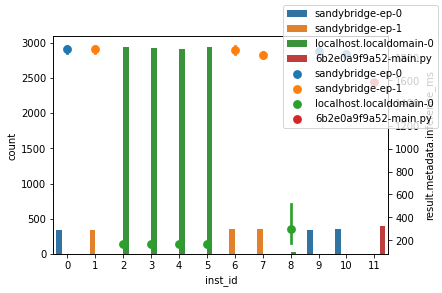

In [11]:
fig = plt.figure()
ax = plt.axes()
ax.set_ylabel("ELat [ms]")
ax.set_xlabel("Time since start [s]")
sns.countplot(ax=ax, data=data, x='inst_id', hue='acc_name')
ax.get_legend().remove()

ax2 = ax.twinx()
ax2.set_ylabel("Requests computed [#]")
sns.pointplot(ax=ax2, data=data, x='inst_id', y='result.metadata.inference_ms', hue='acc_name', join=False)
ax2.get_legend().remove()
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

fig.legend(loc="upper right")

Used Runtime Instances and when they were active


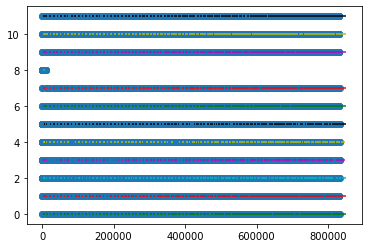

In [12]:
plt.hlines(y=data.inst_id, xmin=data['result.start_computation'], xmax=data['result.end_computation'], colors=data.acc_color, linestyle="solid")
plt.scatter(data.start, data.inst_id)
print("Used Runtime Instances and when they were active")

In [13]:
# Plot by RStart
max = int(data.start.max() / 1000) # Rounds down to the latest second
min = 0 # Per definition for the start
# Plot by EStart
#max = int(data['result.start_computation'].max() / 1000)
#min = int(data['result.start_computation'].min() / 1000)

data_smooth = data.rolling(100).mean()

seconds_d = {
    # Request-Response Latency
    'rlat_min': [],
    'rlat_med': [],
    'rlat_max': [],
    # Execution Start-End Latency
    'elat_min': [],
    'elat_med': [],
    'elat_max': [],
    # Number of successful invocations
    'rsuccess': []
}

for i in range(min, max):
    t_min = i * 1000
    t_max = (i+1) * 1000
    # For Host Selection:
    # (data['result.metadata.hostname'] != 'sandybridge-ep') & 
    # Plot by RStart
    curr = data.loc[(data.start >= t_min) & (data.start < t_max)]
    curr_smooth = data_smooth.loc[(data.start >= t_min) & (data.start < t_max)]
    # Plot by EStart
    #curr = data.loc[(data['result.start_computation'] >= t_min) & (data['result.start_computation'] < t_max)]
    #curr_smooth = data_smooth.loc[(data['result.start_computation'] >= t_min) & (data['result.start_computation'] < t_max)]
    seconds_d['rlat_min'].append(curr.rlat.min())
    seconds_d['rlat_med'].append(curr_smooth.rlat.median())
    seconds_d['rlat_max'].append(curr.rlat.max())
    
    seconds_d['elat_min'].append(curr['result.metadata.inference_ms'].min())
    seconds_d['elat_med'].append(curr_smooth['result.metadata.inference_ms'].median())
    seconds_d['elat_max'].append(curr['result.metadata.inference_ms'].max())
    
    seconds_d['rsuccess'].append(curr.shape[0]) 
    
seconds = pd.DataFrame(seconds_d)
seconds_smooth = seconds.rolling(10).mean()
seconds

/home/trever/.local/share/virtualenvs/python-A7fHczYo/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/trever/.local/share/virtualenvs/python-A7fHczYo/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/trever/.local/share/virtualenvs/python-A7fHczYo/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/trever/.local/share/virtualenvs/python-A7fHczYo/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,rlat_min,rlat_med,rlat_max,elat_min,elat_med,elat_max,rsuccess
0,6304.0,NaN,9388.0,168.534040,NaN,3328.965425,68
1,6105.0,NaN,9288.0,172.322750,NaN,4272.215366,30
2,NaN,NaN,NaN,NaN,NaN,NaN,0
3,NaN,NaN,NaN,NaN,NaN,NaN,0
4,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...
827,NaN,NaN,NaN,NaN,NaN,NaN,0
828,NaN,NaN,NaN,NaN,NaN,NaN,0
829,NaN,NaN,NaN,NaN,NaN,NaN,0
830,9978.0,14167.57,16556.0,138.946772,488.934028,2056.455612,103


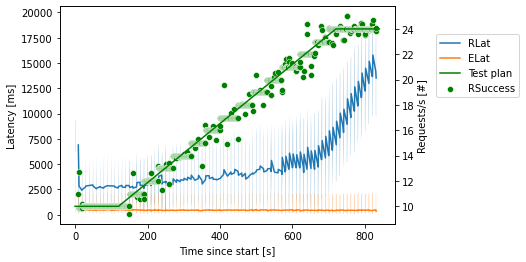

In [14]:
fig = plt.figure()
ax = plt.axes()
ax.set_ylabel("Latency [ms]")
ax.set_xlabel("Time since start [s]")
rlat = sns.lineplot(ax=ax, data=seconds, x=seconds.index, y='rlat_med', label="RLat")
elat = sns.lineplot(ax=ax, data=seconds, x=seconds.index, y='elat_med', label="ELat")
rlats = ax.fill_between(x=seconds.index, y1=seconds['rlat_min'], y2=seconds['rlat_max'], alpha=0.4)
elats = ax.fill_between(x=seconds.index, y1=seconds['elat_min'], y2=seconds['elat_max'], alpha=0.4)
ax.get_legend().remove()

ax2 = ax.twinx()
ax2.set_ylabel("Requests/s [#]")
sns.scatterplot(ax=ax2, data=seconds_smooth, x=seconds.index, y='rsuccess', label="RSuccess", color="g")
sns.lineplot(ax=ax2, x=[0,trps.p0,trps.p0+trps.p1,trps.p0+trps.p1+trps.p2], y=[trps.p0t, trps.p0t, trps.p2t, trps.p2t], color="g", label="Test plan")
ax2.get_legend().remove()
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

fig.legend(loc="upper right", bbox_to_anchor=(1.2, 0.8))

In [15]:
# Read the gpu+queue util as well
util = pd.read_pickle(ps[0] + "_stats.pkl")
util['time'] = util['time'] - experiment_start
experiment_dur = data['end'].max() * 1000
util = util.loc[util['time'] > 0]
util = util.loc[util['time'] < experiment_start + experiment_dur]

util['time'] = util['time']/1000 # convert to seconds
#util

<AxesSubplot:ylabel='Requests/s [#]'>

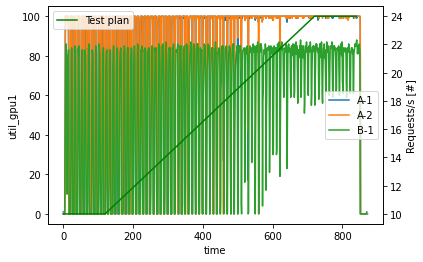

In [16]:
fig = plt.figure()
ax = plt.axes()

sns.lineplot(ax=ax,data=util, x='time', y='util_gpu1', label="A-1")
sns.lineplot(ax=ax,data=util, x='time', y='util_gpu2', label="A-2")
#sns.lineplot(ax=ax,data=util, x='time', y='queued', label="Queued invocations")
sns.lineplot(ax=ax,data=util, x='time', y='util_gpu3', label="B-1")

ax2 = ax.twinx()
ax2.set_ylabel("Requests/s [#]")
sns.lineplot(ax=ax2,x=[0,trps.p0,trps.p0+trps.p1,trps.p0+trps.p1+trps.p2], y=[trps.p0t, trps.p0t, trps.p2t, trps.p2t], color="g", label="Test plan")

<AxesSubplot:ylabel='Requests/s [#]'>

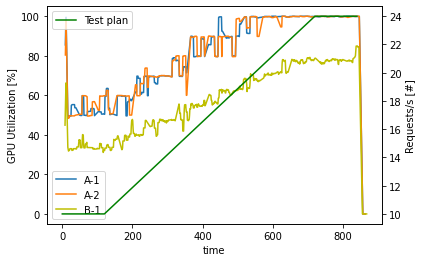

In [17]:
rolling = util.rolling(10).mean()
fig = plt.figure()
ax = plt.axes()
ax.set_ylabel("GPU Utilization [%]")

sns.lineplot(ax=ax,data=rolling, x='time', y='util_gpu1', label="A-1")
sns.lineplot(ax=ax,data=rolling, x='time', y='util_gpu2', label="A-2")
#sns.lineplot(ax=ax,data=util, x='time', y='queued', label="Queued invocations")
sns.lineplot(ax=ax,data=rolling, x='time', y='util_gpu3', label="B-1", color="y")

ax2 = ax.twinx()
ax2.set_ylabel("Requests/s [#]")
sns.lineplot(ax=ax2,x=[0,trps.p0,trps.p0+trps.p1,trps.p0+trps.p1+trps.p2], y=[trps.p0t, trps.p0t, trps.p2t, trps.p2t], color="g", label="Test plan")

In [18]:
util['util_gpu2'].max()

100.0

In [19]:
experiment_start

1625337946712

In [20]:
experiment_dur

851565000

In [21]:
util.loc[util['util_gpu1'] != 0]

,time,util_gpu3,util_mem3,util_gpu1,util_mem1,util_gpu2,util_mem2,queued
10,0.288,NaN,NaN,1.0,0.0,0.0,0.0,0.0
11,1.288,0.0,0.0,NaN,NaN,NaN,NaN,88.0
12,2.288,NaN,NaN,1.0,0.0,0.0,0.0,97.0
13,3.288,0.0,0.0,NaN,NaN,NaN,NaN,88.0
14,4.288,0.0,0.0,1.0,0.0,0.0,0.0,88.0
...,...,...,...,...,...,...,...,...
881,871.288,0.0,1.0,NaN,NaN,NaN,NaN,0.0
882,872.288,0.0,1.0,NaN,NaN,NaN,NaN,0.0
883,873.288,NaN,NaN,NaN,NaN,NaN,NaN,0.0
884,874.288,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [22]:
1624090032000 - experiment_start

-1247914712